This notebook discusses the E(Q) kernel implementation that picks the scattering direction first. After that, the energy and momentum conservation relations can be used to determine the $E_f$, the final neutron energy. In this method, it is necessary to solve a nonlinear equation and it is slow.

We start with the double differential cross section

\begin{equation}
\frac{d^2 \sigma}{d\Omega dE_f} =
\frac{\sigma}{4\pi}
\frac{k_f}{k_i}
N S(Q,E)
\end{equation}

\begin{equation}
 S(Q,E) = S(Q) \times \delta(E-E(Q))
\end{equation}

For now, only consider the part that we need for MC integration

\begin{align}
S(Q,E){d\Omega dE_f} & \propto S(Q) \times \delta(E-E(Q)) {d\Omega dE_f} \\
& \propto \delta(E-E(Q)) {d\Omega dE_f}
\end{align}

$d\Omega$ is easy. Choose one direction randomly and uniformly, and multiply by 4$\pi$

All we care is
\begin{align}
\delta(E-E(Q)) {dE_f}
\end{align}

Define $f(E_f) = E-E(Q) = E_i-E_f - E(Q)$, which is the function that forces the energy and momentum conservation.

So the integration in the end is converted to
* find all $E_f$ or $k_f$ values that satisfy $f(E_f)=0$
* randomly choose just one of them; apply multiplier N_solutions

The implementation is at https://github.com/mcvine/mcvine/blob/24e2e45f46ecf6d4a422556fbba00d7ca9c74ed3/packages/mccomponents/lib/kernels/sample/E_Q_Kernel.icc.random-direction-solve-Ef

To see this implementation working, we need to replace E_Q_Kernel.icc with that file, and recompile mcvine, and then run the following.

In [1]:
import os, numpy as np
import mcni
from mcni.utils import conversion
from mccomponents import mccomponentsbp
import histogram.hdf as hh, histogram as H

In [2]:
from matplotlib import pyplot as plt
%matplotlib notebook

# Simulation using E_Q_kernel

In [3]:
kernel = mccomponentsbp.create_E_Q_Kernel("0", "1", 0, 25, 1., 1.)

In [4]:
vi = np.array((0,0,8000))
ki =conversion.v2k(np.linalg.norm(vi))
print ki

12.706039537


In [5]:
%%time
N = 10000
Qs = []; vfs = []; probs = []
for i in range(N):
    n = mcni.neutron(v=vi)
    kernel.scatter(n)
    vf = np.array(n.state.velocity)
    vdiff = vi - vf
    vdiff_mag = np.linalg.norm(vdiff)
    Q = conversion.v2k(vdiff_mag)
    p = n.probability
    Qs.append(Q); vfs.append(vf); probs.append(p)
    continue

CPU times: user 1.42 s, sys: 0 ns, total: 1.42 s
Wall time: 1.42 s


## histogram

In [6]:
dQ = 0.1

In [7]:
hist, Qbb = np.histogram(Qs, weights=probs, bins=np.arange(0, 2*ki, dQ))

In [8]:
Qcenters = (Qbb[1:] + Qbb[:-1])/2

<IPython.core.display.Javascript object>


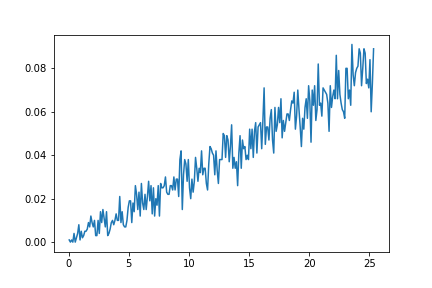

In [10]:
plt.figure()
plt.plot(Qcenters, hist/N/dQ)

This should match IsotropicKernel and it does.

# Simulation of a sin wave using E_Q_kernel

In [11]:
kernel = mccomponentsbp.create_E_Q_Kernel("20+30*sin(Q/2.*3.14159)^2", "1", 0, 25, 1., 1.)

In [12]:
vi_vector = np.array((0,0,4000))
vi = np.linalg.norm(vi_vector)
ki =conversion.v2k(vi)
print ki
Ei = conversion.v2e(vi)
print Ei

6.35301976852
83.632620117


In [13]:
%%time
N = 100000
Qs = []; Es = []; vfs = []; probs = []
for i in range(N):
    n = mcni.neutron(v=vi_vector)
    kernel.scatter(n)
    vf_vector = np.array(n.state.velocity)
    vf = np.linalg.norm(vf_vector)
    Ef = conversion.v2e(vf)
    E = Ei - Ef; Es.append(E)
    vdiff_vector = vi_vector - vf_vector
    vdiff = np.linalg.norm(vdiff_vector)
    Q = conversion.v2k(vdiff)
    p = n.probability
    Qs.append(Q); vfs.append(vf_vector); probs.append(p)
    continue

CPU times: user 48.7 s, sys: 20 ms, total: 48.7 s
Wall time: 48.7 s


## histogram

In [18]:
dQ = 0.05; dE=.25

In [19]:
hist, Qbb, Ebb = np.histogram2d(Qs, Es, weights=probs, bins=(np.arange(0, 2*ki, dQ), np.arange(0, Ei, dE)))

In [20]:
Qcenters = (Qbb[1:] + Qbb[:-1])/2
Ecenters = (Ebb[1:] + Ebb[:-1])/2

<IPython.core.display.Javascript object>


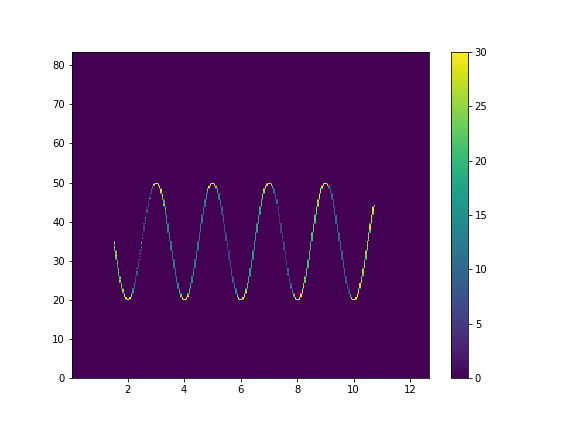

In [22]:
plt.figure(figsize=(8,6))
Qmesh,Emesh = np.meshgrid(Qcenters, Ecenters)
plt.pcolormesh(Qmesh, Emesh, hist.T/Qmesh)  # /Qmesh is equivalent to solid angle normalization. See IstropicKernel
plt.clim(0, 30)
plt.colorbar()